In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import sys
module_path = os.path.abspath(os.path.join('/Users/arthurstrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Qiskit imports
from qiskit import pulse, transpile
from qiskit.transpiler import InstructionDurations, InstructionProperties
from qiskit.circuit import ParameterVector, QuantumCircuit, QuantumRegister, Gate, CircuitInstruction, Parameter
from qiskit.circuit.library import get_standard_gate_name_mapping

from qiskit.providers.fake_provider import FakeHanoi, FakeJakarta, FakeJakartaV2
from qiskit_dynamics import DynamicsBackend, Solver
from qiskit_experiments.calibration_management import Calibrations
from qiskit_experiments.library import RoughXSXAmplitudeCal, RoughDragCal
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon, EchoedCrossResonance

from itertools import permutations
import numpy as np
import tqdm
import time
from typing import Union, Optional, List, Sequence, Dict
from IPython.display import clear_output
import jax
jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")
# import Array and set default backend
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')

/Users/arthurstrauss/opt/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [3]:
def perform_standard_calibrations(
    backend: DynamicsBackend, calibration_files: Optional[List[str]] = None
):
    """
    Generate baseline single qubit gates (X, SX, RZ, H) for all qubits using traditional calibration experiments
    :param backend: Dynamics Backend on which calibrations should be run
    :param calibration_files: Optional calibration files containing single qubit gate calibrations for provided
        DynamicsBackend instance (Qiskit Experiments does not support this feature yet)

    """

    target, qubits = backend.target, []
    for i, dim in enumerate(backend.options.subsystem_dims):
        if dim > 1:
            qubits.append(i)
    num_qubits = len(qubits)
    single_qubit_properties = {(qubit,): None for qubit in range(num_qubits)}
    single_qubit_errors = {(qubit,): 0.0 for qubit in qubits}

    control_channel_map = backend.options.control_channel_map or {
        (qubits[0], qubits[1]): index
        for index, qubits in enumerate(tuple(permutations(qubits, 2)))
    }
    if backend.options.control_channel_map:
        physical_control_channel_map = {
            (qubit_pair[0], qubit_pair[1]): backend.control_channel(
                (qubit_pair[0], qubit_pair[1])
            )
            for qubit_pair in backend.options.control_channel_map
        }
    else:
        physical_control_channel_map = {
            (qubit_pair[0], qubit_pair[1]): [pulse.ControlChannel(index)]
            for index, qubit_pair in enumerate(tuple(permutations(qubits, 2)))
        }
    backend.set_options(control_channel_map=control_channel_map)
    coupling_map = [list(qubit_pair) for qubit_pair in control_channel_map]
    two_qubit_properties = {qubits: None for qubits in control_channel_map}
    two_qubit_errors = {qubits: 0.0 for qubits in control_channel_map}
    standard_gates: Dict[
        str, Gate
    ] = get_standard_gate_name_mapping()  # standard gate library
    fixed_phase_gates, fixed_phases = ["z", "s", "sdg", "t", "tdg"], np.pi * np.array(
        [1, 0.5, -0.5, 0.25, -0.25]
    )
    other_gates = ["rz", "id", "h", "x", "sx", "reset"]
    single_qubit_gates = fixed_phase_gates + other_gates
    two_qubit_gates = ["ecr"]
    exp_results = {}
    existing_cals = calibration_files is not None

    phi: Parameter = standard_gates["rz"].params[0]
    if existing_cals:
        cals = Calibrations.load(files=calibration_files)
    else:
        cals = Calibrations(
            coupling_map=coupling_map,
            control_channel_map=physical_control_channel_map,
            libraries=[
                FixedFrequencyTransmon(basis_gates=["x", "sx"]),
                EchoedCrossResonance(basis_gates=["cr45p", "cr45m", "ecr"]),
            ],
            backend_name=backend.name,
            backend_version=backend.backend_version,
        )
    if (
        len(target.instruction_schedule_map().instructions) <= 1
    ):  # Check if instructions have already been added
        for gate in single_qubit_gates:
            target.add_instruction(
                standard_gates[gate], properties=single_qubit_properties
            )
        if num_qubits > 1:
            for gate in two_qubit_gates:
                target.add_instruction(
                    standard_gates[gate], properties=two_qubit_properties
                )
            target.build_coupling_map(two_q_gate=two_qubit_gates[0])

    for qubit in qubits:  # Add calibrations for each qubit
        control_channels = list(
            filter(
                lambda x: x is not None,
                [control_channel_map.get((i, qubit), None) for i in qubits],
            )
        )
        # Calibration of RZ gate, virtual Z-rotation
        with pulse.build(backend, name=f"rz{qubit}") as rz_cal:
            pulse.shift_phase(-phi, pulse.DriveChannel(qubit))
            for q in control_channels:
                pulse.shift_phase(-phi, pulse.ControlChannel(q))
        # Identity gate
        id_cal = pulse.Schedule(
            pulse.Delay(20, pulse.DriveChannel(qubit))
        )  # Wait 20 cycles for identity gate

        # Update backend Target by adding calibrations for all phase gates (fixed angle virtual Z-rotations)
        target.update_instruction_properties(
            "rz", (qubit,), InstructionProperties(calibration=rz_cal, error=0.0)
        )
        target.update_instruction_properties(
            "id", (qubit,), InstructionProperties(calibration=id_cal, error=0.0)
        )
        target.update_instruction_properties(
            "reset", (qubit,), InstructionProperties(calibration=id_cal, error=0.0)
        )
        for phase, gate in zip(fixed_phases, fixed_phase_gates):
            gate_cal = rz_cal.assign_parameters({phi: phase}, inplace=False)
            instruction_prop = InstructionProperties(calibration=gate_cal, error=0.0)
            target.update_instruction_properties(gate, (qubit,), instruction_prop)

        # Perform calibration experiments (Rabi/Drag) for calibrating X and SX gates
        if not existing_cals:
            rabi_exp = RoughXSXAmplitudeCal(
                [qubit], cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 100)
            )
            drag_exp = RoughDragCal(
                [qubit], cals, backend=backend, betas=np.linspace(-20, 20, 15)
            )
            drag_exp.set_experiment_options(reps=[3, 5, 7])
            print(f"Starting Rabi experiment for qubit {qubit}...")
            rabi_result = rabi_exp.run().block_for_results()
            print(f"Rabi experiment for qubit {qubit} done.")
            print(f"Starting Drag experiment for qubit {qubit}...")
            drag_result = drag_exp.run().block_for_results()
            print(f"Drag experiments done for qubit {qubit} done.")
            exp_results[qubit] = [rabi_result, drag_result]

        # Build Hadamard gate schedule from following equivalence: H = S @ SX @ S

        # sx_schedule = block_to_schedule(cals.get_schedule("sx", (qubit,)))
        # s_schedule = block_to_schedule(target.get_calibration("s", (qubit,)))
        # h_schedule = pulse.Schedule(s_schedule, sx_schedule, s_schedule, name="h")
        sx_schedule = cals.get_schedule("sx", (qubit,))
        s_schedule = target.get_calibration("s", (qubit,))
        with pulse.build(backend, name="h") as h_schedule:
            pulse.call(s_schedule)
            pulse.call(sx_schedule)
            pulse.call(s_schedule)

        target.update_instruction_properties(
            "h",
            (qubit,),
            properties=InstructionProperties(calibration=h_schedule, error=0.0),
        )

    print("All single qubit calibrations are done")
    # cals.save(file_type="csv", overwrite=True, file_prefix="Custom" + backend.name)
    error_dict = {"x": single_qubit_errors, "sx": single_qubit_errors}
    target.update_from_instruction_schedule_map(
        cals.get_inst_map(), error_dict=error_dict
    )
    print(control_channel_map)
    # for qubit_pair in control_channel_map:
    #     print(qubit_pair)
    #     cr_ham_exp = CrossResonanceHamiltonian(physical_qubits=qubit_pair, flat_top_widths=np.linspace(0, 5000, 17),
    #                                            backend=backend)
    #     print("Calibrating CR for qubits", qubit_pair, "...")
    #     data_cr = cr_ham_exp.run().block_for_results()
    #     exp_results[qubit_pair] = data_cr

    print("Updated Instruction Schedule Map", target.instruction_schedule_map())

    return cals, exp_results

In [4]:
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver, Signal
dim = 2
dt = 1/4.5e9
v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

X = Operator.from_label('X')
Z = Operator.from_label('Z')

solver = Solver(
    static_hamiltonian=.5 * 2 * np.pi * v0 * Z,
    hamiltonian_operators=[2 * np.pi * r0 * X],
    rotating_frame = .5 * 2 * np.pi * v0 * Z,
    hamiltonian_channels=["d0"],
    channel_carrier_freqs={"d0": v0},
    dt=dt,
    evaluation_mode="dense"
    
)

In [5]:
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, 'hmax':dt}

backend = DynamicsBackend(
    solver=solver,
    subsystem_dims=[dim], # for computing measurement data
    solver_options=solver_options, # to be used every time run is called
)
cals, exp_results = perform_standard_calibrations(backend)

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
All single qubit calibrations are done
{}
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'rz', 'id', 't', 'sx', 'tdg', 'sdg', 'x', 'measure', 'z', 'h', 's', 'reset'}
Multi qubit instructions:
)>


In [6]:
from qiskit.quantum_info import Statevector
from qiskit.circuit import ParameterVector
y0 = Array(Statevector(np.array([1.0, 0.0])))
dt = 2.222e-10
rtol = 1e-8
atol = 1e-6
phase_params = ParameterVector('phase', 3)
h_sched = backend.target.get_calibration("h", (0,))
x_sched = backend.target.get_calibration("x", (0,))
meas_sched = backend.target.get_calibration("measure", (0,))
# build a pulse schedule
with pulse.build(default_alignment="sequential") as sched_ext:
    #pulse.call(x_sched)
    pulse.call(h_sched)
    pulse.shift_phase(phase_params[0], pulse.DriveChannel(0))
    pulse.call(h_sched)
    
t_linspace = np.linspace(0.0, sched_ext.duration*dt, 100)
print(sched_ext.duration)

320


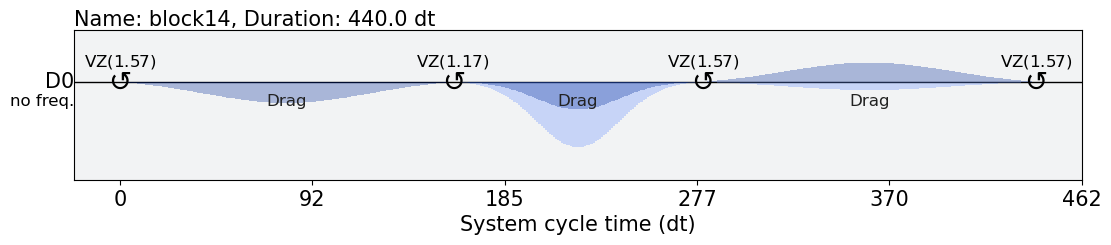

In [12]:
def my_sched():
    with pulse.build(default_alignment="sequential") as sched_ext:
        #pulse.call(x_sched)
        pulse.call(h_sched)
        pulse.shift_phase(phase_params[0], pulse.DriveChannel(0))
        pulse.shift_phase(phase_params[1], pulse.DriveChannel(0))
        pulse.shift_phase(phase_params[2], pulse.DriveChannel(0))
        pulse.play(pulse.Drag(amp=phase_params[2], duration=120, sigma=20, angle=0., beta=0.), pulse.DriveChannel(0))
        pulse.call(h_sched)
    return sched_ext

def my_clean_sched(param):
    with pulse.build(default_alignment="sequential") as sched_ext:
        #pulse.call(x_sched)
        pulse.call(h_sched)
        pulse.shift_phase(0.4, pulse.DriveChannel(0))
        pulse.play(pulse.Drag(amp=param, duration=120, sigma=20, angle=0., beta=0.), pulse.DriveChannel(0))
        pulse.call(h_sched)
    return sched_ext
my_clean_sched(0.2).draw()

In [10]:
# Inside jit function method
import jax.numpy as jnp
from jax import block_until_ready, vmap
from qiskit_dynamics.array import wrap
jit = wrap(jax.jit, decorator=True)
qd_vmap = wrap(vmap, decorator=True)


def get_sched(phases):
    #sched_in = my_sched().assign_parameters({param:phase for (param, phase) in zip(phase_params, phases)}, inplace = False)
    with pulse.build(default_alignment="sequential") as sched_in:
        #pulse.call(x_sched)
        pulse.call(h_sched)
        pulse.shift_phase(0.4, pulse.DriveChannel(0))
        pulse.play(pulse.Drag(amp=0.2, duration=160, sigma=phases, angle=0., beta=0.), pulse.DriveChannel(0))
        pulse.call(h_sched)
        
    t_linspace = jnp.linspace(0, 320*dt, 20)
    results = solver.solve(t_span=[t_linspace[0], t_linspace[-1]],
        y0=y0,
        signals=sched_in,
        #signals=sched,
        #t_eval=t_linspace[-1],
        method='jax_odeint',
        atol=atol,
        rtol=rtol,
        hmax = dt
    )
    
    return results.y
sched_fast = jit(get_sched)

In [11]:
#sched_fast([np.pi, np.pi/2, 0.3])
sched_fast(20)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape int64[].
The error occurred while tracing the function get_sched at /var/folders/82/30qkl1t503n87c1769x88frm0000gp/T/ipykernel_1687/1116097504.py:9 for jit. This concrete value was not available in Python because it depends on the value of the argument phases.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [ ]:
param = Parameter("theta")
with pulse.build(default_alignment="sequential") as sched:
    #pulse.call(x_sched)
    #pulse.call(h_sched)
    pulse.play(pulse.Drag(amp=0.2, duration=120, sigma = 20, beta =0, angle= param), pulse.DriveChannel(0))
s = jnp.float64(0.2)
sched

In [ ]:
s

In [ ]:
import sympy2jax
import sympy
import jax.numpy as jnp

x_sym = sympy.symbols("x_sym")
y_sym = sympy.symbols("y_sym")
cosx = 1.0 * sympy.cos(x_sym) + 1.0 * sympy.cos(y_sym)
sinx = 2.0 * sympy.sin(x_sym) + 2.0 * sympy.sin(y_sym)
mod = sympy2jax.SymbolicModule([cosx, sinx])  # PyTree of input expressions
type(cosx)
info = {x_sym.name: x, y_sym.name: y}

In [ ]:
x_sym.name

In [ ]:
x = jnp.zeros(3)
y = jnp.ones(3)
out = mod(**info)
out

In [ ]:
param = Parameter("amp")
param2 = Parameter("amp2")
param3 = 2*param
param3._parameter_symbols
type(param3._symbol_expr)
param4 = sympy.sympify(param3._symbol_expr)
type(param4)

In [ ]:
for key, value in param2._parameter_symbols.items():
    print(type(key), type(value))

In [ ]:
qc = QuantumCircuit(1)
phi = Parameter("phi")
qc.rx(2*phi, 0)
qc.draw("mpl")

In [ ]:
qc.bind_parameters([0.5]).draw("mpl")

In [ ]:
x_pulse = backend.target.get_calibration("x", (0,)).instructions[0][1].pulse
x_pulse

In [ ]:
setattr(x_pulse, 'amp', 0.3)
x_pulse